In [189]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob
from pmdarima import auto_arima
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

We now have a news dataset spanning 10 csv files based on keywords - "US election", "Dow Jones", "S&P 500", "Nasdaq", "Trump", "stock market", "Elon Musk", "Swing States", "Inflation", "Federal reserve rate" - from GDELT. This is stored in 10 separate files as each one has huge amount of data stored in them. Lets process the data.
We also have dataset spanning 5 csv files for stock market - "Dow Jones", "Nasdaq", "S&P 500", "Bitcoin", "Dogecoin" retrived from YahooFinance. Lets also process this data.

In [190]:
#Lets check news data from GDELT. We can check for one case and then might as well apply the same rules to all the 10 csv files. I will showcase the final method here.

def initial_cleanup(file):
        df = pd.read_csv('newsdataset/'+file+'.csv')
        df.columns = ["url", "url_mobile", "title", "seenDate", "socialImage", "domain", "language", "sourceCountry"]

        #We dont see The columns 'url', 'url_mobile', 'socialimage' adding much value. lets remove them. 
        df.drop(columns=["url", "url_mobile", "socialImage"], inplace=True)

        #Convert seenDate to easily understandable format
        df["seenDate"] = pd.to_datetime(df["seenDate"], format="%Y%m%dT%H%M%SZ")


        return df

In [191]:
df_DJ = initial_cleanup('gdelt_Dow_Jones')
df_elon = initial_cleanup('gdelt_Elon_Musk')
df_federalreserve = initial_cleanup('gdelt_Federal_reserve_rate')
df_inflation = initial_cleanup('gdelt_Inflation')
df_nasdaq = initial_cleanup('gdelt_Nasdaq')
df_snp = initial_cleanup('gdelt_S&P_500')
df_stock = initial_cleanup('gdelt_stock_market')
df_swingstates = initial_cleanup('gdelt_Swing_States')
df_trump = initial_cleanup('gdelt_Trump')
df_election = initial_cleanup('gdelt_US_election')

In [192]:
#merge all dataframes 
df_news = pd.concat([df_DJ, df_elon, df_federalreserve, df_inflation, df_nasdaq, df_snp, df_stock, df_swingstates, df_trump, df_election], ignore_index=True)
df_news.shape

(158436, 5)

In [193]:
#our dataset is ready. Now lets just get basic info about the dataset
print("Dataset Shape:", df_news.shape)
print("\nColumn Info:")
print(df_news.info())

Dataset Shape: (158436, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158436 entries, 0 to 158435
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   title          158410 non-null  object        
 1   seenDate       158436 non-null  datetime64[ns]
 2   domain         158436 non-null  object        
 3   language       158436 non-null  object        
 4   sourceCountry  158436 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.0+ MB
None


In [194]:
#lets now analyse columns
#remove null values

for col in df_news.columns:
    null_count = df_news[col].isnull().sum()
    print(f"Number of null values in column {col}: {null_count}")

Number of null values in column title: 26
Number of null values in column seenDate: 0
Number of null values in column domain: 0
Number of null values in column language: 0
Number of null values in column sourceCountry: 0


In [195]:
#title is the most needed column. Without that we cannot perform sentiment analysis. Lets remove the null values from it. We dont need those rows.
df_news_nonnull = df_news.dropna(subset=["title"])
df_news_nonnull.shape

(158410, 5)

['English' 'Korean' 'Russian' 'Arabic' 'Swedish' 'Telugu' 'Spanish'
 'Japanese' 'French' 'Ukrainian' 'Hungarian' 'Turkish' 'Greek' 'German'
 'Italian' 'Macedonian' 'Chinese' 'Persian' 'Finnish' 'Dutch' 'Danish'
 'Icelandic' 'Slovak' 'Polish' 'Indonesian']


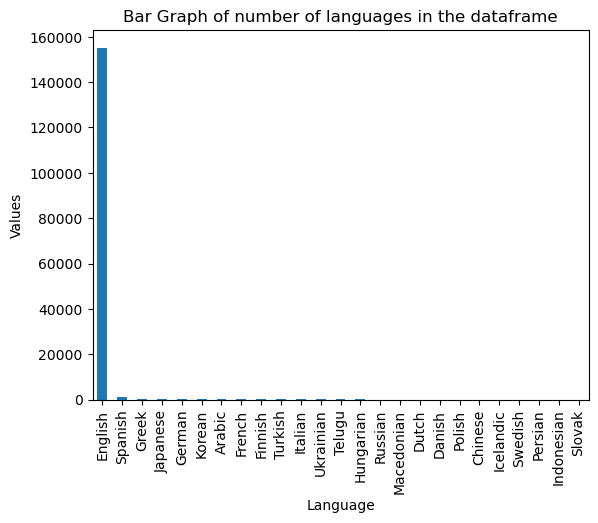

In [196]:
#lets check if we have any other language other than english. For simplicity, lets just have data in english
print(df_news_nonnull['language'].unique())

df_news_nonnull['language'].value_counts().plot(kind='bar')
plt.title('Bar Graph of number of languages in the dataframe')
plt.xlabel('Language')
plt.ylabel('Values')
plt.show()

There are too many languages we dont need. Lets just take a subset of the dataframe with language = english

(155188, 5)


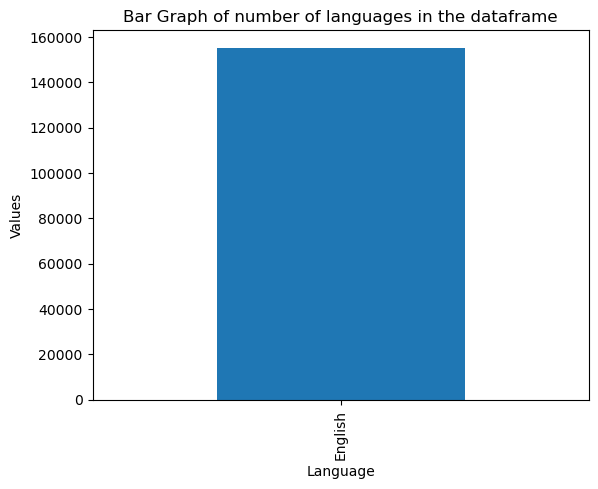

In [197]:

df_news_nonnull_english = df_news_nonnull[df_news_nonnull['language'] == 'English']
print(df_news_nonnull_english.shape)

df_news_nonnull_english['language'].value_counts().plot(kind='bar')
plt.title('Bar Graph of number of languages in the dataframe')
plt.xlabel('Language')
plt.ylabel('Values')
plt.show()

/var/folders/55/x837yjcj345fvyz78_wh348h0000gn/T/ipykernel_9755/3411084330.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



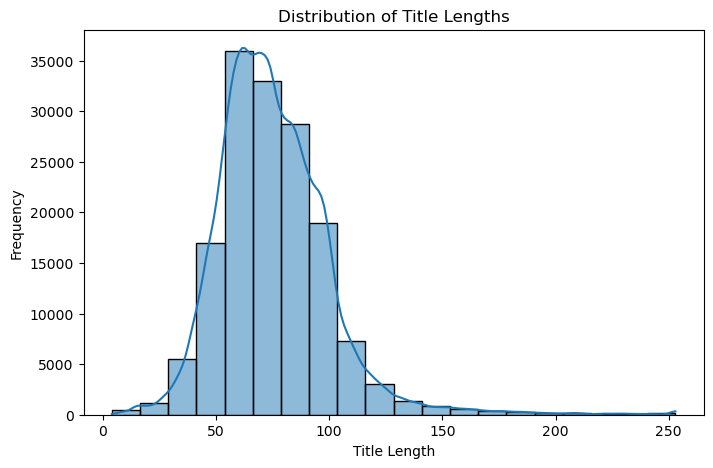

In [198]:
#Lets check title

df_news_nonnull_english["title_length"] = df_news_nonnull_english["title"].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df_news_nonnull_english["title_length"], bins=20, kde=True)
plt.title("Distribution of Title Lengths")
plt.xlabel("Title Length")
plt.ylabel("Frequency")
plt.show()

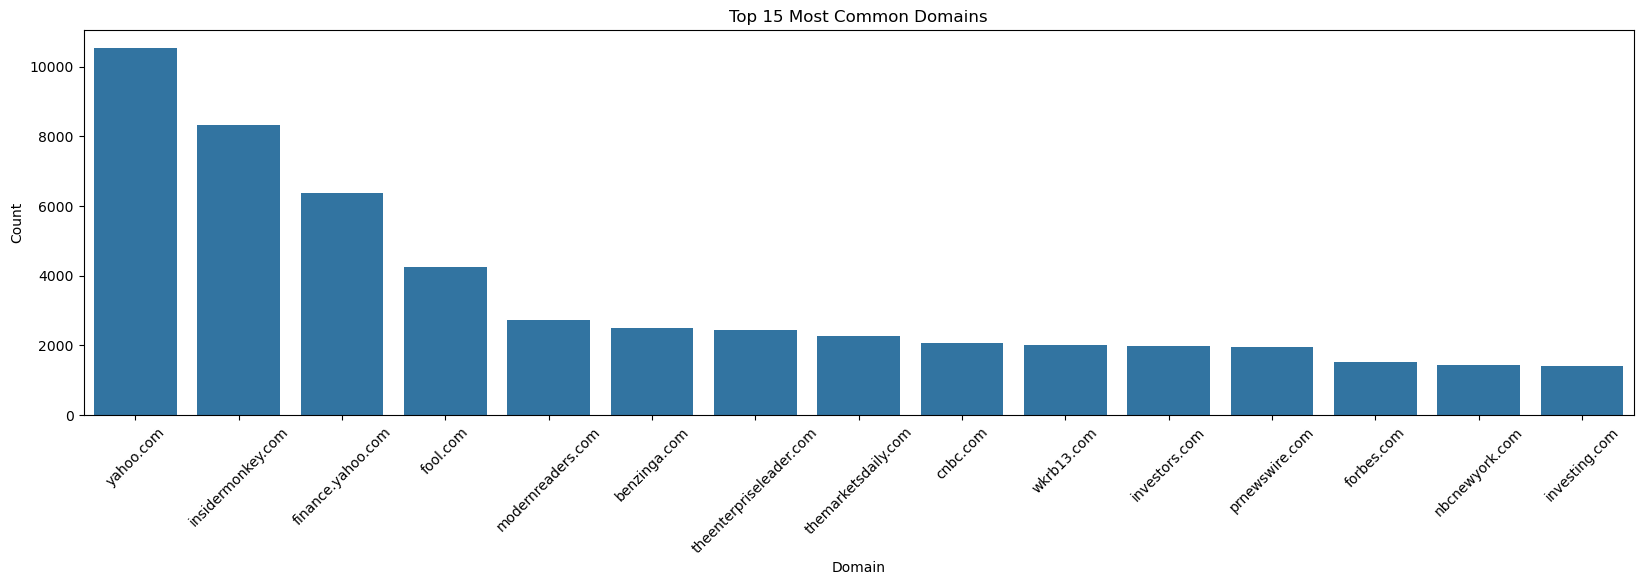

In [199]:
#Now lets check for the most common domains
top_domains = df_news_nonnull_english["domain"].value_counts().head(15)

plt.figure(figsize=(20, 5))
sns.barplot(x=top_domains.index, y=top_domains.values)
plt.xticks(rotation=45)
plt.title("Top 15 Most Common Domains")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.show()

/var/folders/55/x837yjcj345fvyz78_wh348h0000gn/T/ipykernel_9755/2015428998.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



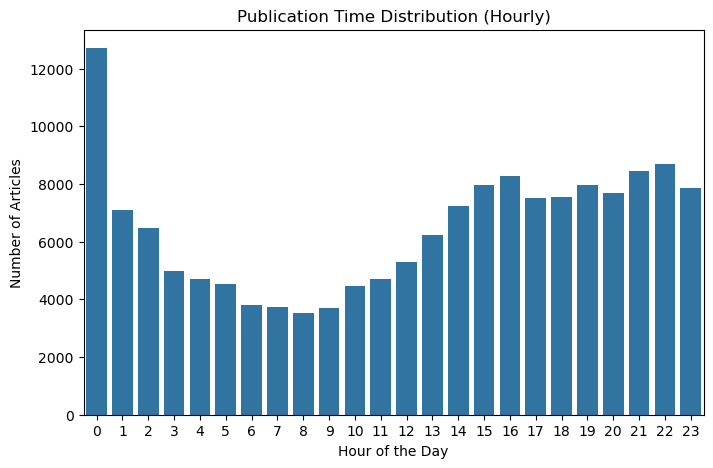

In [200]:
#Lets also check for article publication trends

df_news_nonnull_english["hour"] = df_news_nonnull_english["seenDate"].dt.hour

plt.figure(figsize=(8, 5))
sns.countplot(x=df_news_nonnull_english["hour"], order=sorted(df_news_nonnull_english["hour"].unique()))
plt.title("Publication Time Distribution (Hourly)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Articles")
plt.show()

Now that we have cleaned dataset, lets start with text processing. note that only 'title' field is of importance to us for sentiment analysis. lets start with text processing on it. 
We can do convert to lowercase, remove punctuation & special characters, tokenization, remove Stopword, lemmatize

In [201]:
#Lets start by making a copy of the dataframe
df_news_cleaned = df_news_nonnull_english.copy()

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
custom_stopwords = set(["u", "p", "s", "amp", "b", "c", "d", "e", "f", "g", "h", "j", "k", "l", "m", "n", "o", "q", "r", "t", "v", "w", "x", "y", "z"])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [202]:
#Text processing 
nltk.download('punkt_tab')
def preprocess_text(text):

    #Convert to lowercase
    text = text.lower()

    #Remove punctuation & special characters
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)  

    #Tokenization
    words = word_tokenize(text)  

    #Stopword removal
    words = [word for word in words if word not in stop_words] 
    words =  [word for word in words if word not in  custom_stopwords] 

    #Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]  
    return " ".join(words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/krupakrishnamurthy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [203]:
df_news_cleaned["cleaned_title"] = df_news_cleaned["title"].apply(preprocess_text)
print(df_news_cleaned.head())

                                               title            seenDate  \
0  Advisory Alpha LLC Increases Stock Position in... 2024-10-01 20:30:00   
1  Iran readying  imminent  ballistic missile att... 2024-10-01 14:45:00   
2  Stock futures are little changed following roc... 2024-10-01 22:30:00   
3  Stock futures are little changed following roc... 2024-10-01 22:30:00   
4  Dow notches another closing record after encou... 2024-10-01 01:00:00   

                 domain language  sourceCountry  title_length  hour  \
0      tickerreport.com  English  United States           110    20   
1        nbcnewyork.com  English  United States           113    14   
2     nbclosangeles.com  English  United States            80    22   
3    nbcconnecticut.com  English  United States            80    22   
4  insurancenewsnet.com  English  United States            66     1   

                                       cleaned_title  
0  advisory alpha llc increase stock position spd...  
1  ira

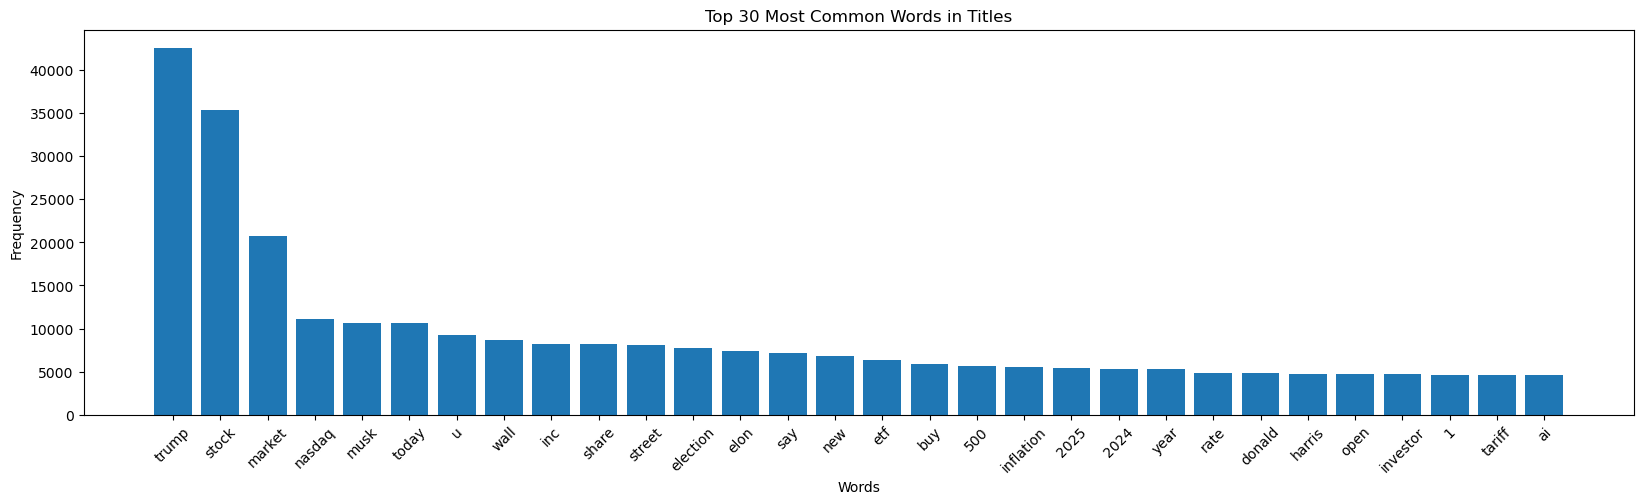

In [204]:
def get_word_frequencies(text_series):
    all_words = " ".join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(30)

word_freq = get_word_frequencies(df_news_cleaned["cleaned_title"])

words, counts = zip(*word_freq)
plt.figure(figsize=(20,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 30 Most Common Words in Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

The bar chart displays the top 30 most common words in news article titles, with "Trump," "stock," and "market" being the most frequently mentioned terms. This suggests a strong focus on political figures and financial markets in the news dataset.

In [205]:
df_news_cleaned.head()

,title,seenDate,domain,language,sourceCountry,title_length,hour,cleaned_title
0,Advisory Alpha LLC Increases Stock Position in...,2024-10-01 20:30:00,tickerreport.com,English,United States,110,20,advisory alpha llc increase stock position spd...
1,Iran readying imminent ballistic missile att...,2024-10-01 14:45:00,nbcnewyork.com,English,United States,113,14,iran readying imminent ballistic missile attac...
2,Stock futures are little changed following roc...,2024-10-01 22:30:00,nbclosangeles.com,English,United States,80,22,stock future little changed following rocky st...
3,Stock futures are little changed following roc...,2024-10-01 22:30:00,nbcconnecticut.com,English,United States,80,22,stock future little changed following rocky st...
4,Dow notches another closing record after encou...,2024-10-01 01:00:00,insurancenewsnet.com,English,United States,66,1,dow notch another closing record encouraging p...


In [206]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_news_cleaned["sentiment_score"] = df_news_cleaned["cleaned_title"].apply(get_sentiment)

In [207]:
def categorize_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

df_news_cleaned["sentiment_label"] = df_news_cleaned["sentiment_score"].apply(categorize_sentiment)

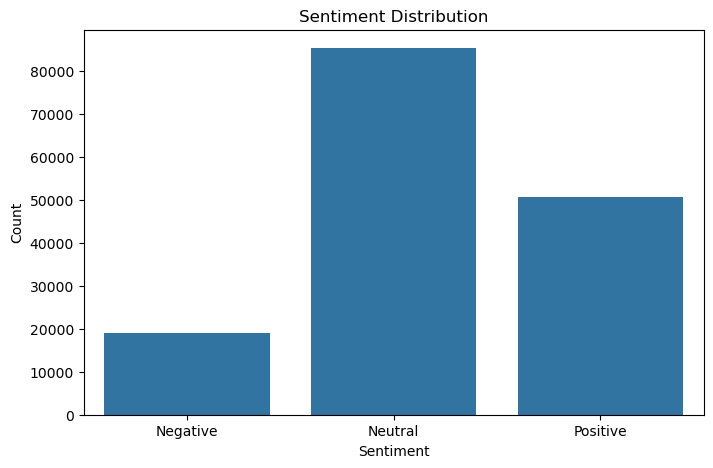

In [208]:
# Sentiment Distribution Plot
plt.figure(figsize=(8, 5))
sns.countplot(x=df_news_cleaned["sentiment_label"].sort_values())
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Most of the news articles are neutral, meaning they likely report facts rather than strong opinions. There's more positive sentiment than negative, suggesting that media coverage leans slightly optimistic or focuses on encouraging narratives rather than critical or alarming ones.

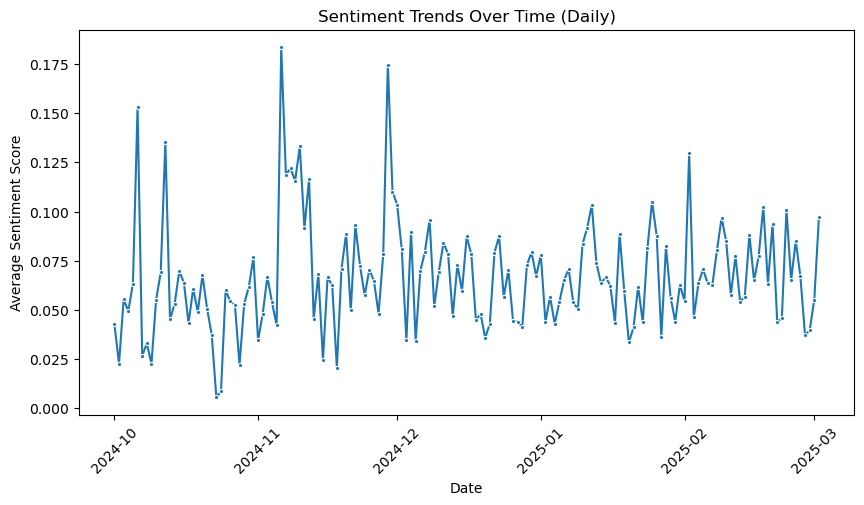

In [209]:
# Extract date from seenDate column
df_news_cleaned["date"] = df_news_cleaned["seenDate"].dt.date

# Sentiment Trends Over Time
sentiment_trend = df_news_cleaned.groupby("date")["sentiment_score"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=sentiment_trend.index, y=sentiment_trend.values, marker=".")
plt.xticks(rotation=45)
plt.title("Sentiment Trends Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.show()


The news sentiment goes up and down, with some days being more positive and others more negative. Overall, it stays mostly positive, but there are a few drops, likely when big negative events happened.

We have completed basic analysis and EDA for news dataset. Let us move on to stock market dataset. We have five files here as well - one for each of Nasdaq, Dow jones, S&P 500, Bitcoin and Dogecoin.


In [210]:
df_stock_DJ = pd.read_csv('stockdataset/Dow_Jones_Stock_Data.csv')
df_stock_DJ = df_stock_DJ.drop([0,1])
df_stock_DJ = df_stock_DJ.rename(columns={'Price': 'Date', 'Close': 'ClosingPrice', 'High': 'HighPrice', 'Low':'LowPrice', 'Open':'OpenPrice'})
df_stock_DJ['Stock'] = 'DowJones'
print(df_stock_DJ.shape)
df_stock_DJ.head()

(103, 7)


,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock
2,2024-10-01,42156.96875,42322.359375,41945.62890625,42262.96875,380240000,DowJones
3,2024-10-02,42196.51953125,42259.51953125,41968.7890625,42125.140625,301760000,DowJones
4,2024-10-03,42011.58984375,42125.83984375,41847.80859375,42099.53125,267260000,DowJones
5,2024-10-04,42352.75,42361.37890625,41972.109375,42248.26171875,296550000,DowJones
6,2024-10-07,41954.23828125,42293.640625,41831.73828125,42289.51171875,307230000,DowJones


In [211]:
df_stock_Nasdaq = pd.read_csv('stockdataset/Nasdaq_Stock_Data.csv')
df_stock_Nasdaq['Stock'] = 'Nasdaq'
print(df_stock_Nasdaq.shape)
df_stock_Nasdaq.head()

(105, 7)


,Price,Close,High,Low,Open,Volume,Stock
0,Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC,Nasdaq
1,Date,NaN,NaN,NaN,NaN,NaN,Nasdaq
2,2024-10-01,17910.359375,18162.720703125,17779.76953125,18154.939453125,5879980000,Nasdaq
3,2024-10-02,17925.119140625,17978.580078125,17767.7890625,17867.119140625,5489040000,Nasdaq
4,2024-10-03,17918.48046875,18011.25,17826.419921875,17859.490234375,5208990000,Nasdaq


In [212]:
df_stock_SNP = pd.read_csv('stockdataset/S&P_500_Stock_Data.csv')
df_stock_SNP['Stock'] = 'S&P500'
print(df_stock_SNP.shape)
df_stock_SNP.head()

(105, 7)


,Price,Close,High,Low,Open,Volume,Stock
0,Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,S&P500
1,Date,NaN,NaN,NaN,NaN,NaN,S&P500
2,2024-10-01,5708.75,5757.72998046875,5681.27978515625,5757.72998046875,4025180000,S&P500
3,2024-10-02,5709.5400390625,5719.6298828125,5674.0,5698.14013671875,3829050000,S&P500
4,2024-10-03,5699.93994140625,5718.77978515625,5677.3701171875,5698.18994140625,3597450000,S&P500


In [213]:
df_stock_Bitcoin = pd.read_csv('stockdataset/Bitcoin_Index_Stock_Data.csv')
df_stock_Bitcoin['Stock'] = 'Bitcoin'
print(df_stock_Bitcoin.shape)
df_stock_Bitcoin.head()

(105, 7)


,Price,Close,High,Low,Open,Volume,Stock
0,Ticker,BTC,BTC,BTC,BTC,BTC,Bitcoin
1,Date,NaN,NaN,NaN,NaN,NaN,Bitcoin
2,2024-10-01,27.399999618530273,28.149999618530273,27.049999237060547,28.100000381469727,1533700,Bitcoin
3,2024-10-02,26.700000762939453,27.649999618530273,26.600000381469727,27.0,1738180,Bitcoin
4,2024-10-03,27.049999237060547,27.100000381469727,26.549999237060547,26.799999237060547,995900,Bitcoin


In [214]:
df_stock_Dogecoin = pd.read_csv('stockdataset/Dogecoin_Stock_Data.csv')
df_stock_Dogecoin['Stock'] = 'Dogecoin'
print(df_stock_Dogecoin.shape)
df_stock_Dogecoin.head()

(153, 7)


,Price,Close,High,Low,Open,Volume,Stock
0,Ticker,DOGE-USD,DOGE-USD,DOGE-USD,DOGE-USD,DOGE-USD,Dogecoin
1,Date,NaN,NaN,NaN,NaN,NaN,Dogecoin
2,2024-10-01,0.10704299807548523,0.11927399784326553,0.10395500063896179,0.11442700028419495,1332235464,Dogecoin
3,2024-10-02,0.10475900024175644,0.10941100120544434,0.10250899940729141,0.10704299807548523,910153432,Dogecoin
4,2024-10-03,0.10509900003671646,0.10663799941539764,0.10152900218963623,0.10475800186395645,825842052,Dogecoin


In [215]:
print(df_stock_DJ.columns)
print(df_stock_Nasdaq.columns)
print(df_stock_SNP.columns)
print(df_stock_Bitcoin.columns)
print(df_stock_Dogecoin.columns)


Index(['Date', 'ClosingPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume',
       'Stock'],
      dtype='object')
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='object')
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='object')
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='object')
Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock'], dtype='object')


In [216]:
standard_columns = ["Date", "ClosingPrice", "HighPrice", "LowPrice", "OpenPrice", "Volume", "Stock"]

df_stock_Nasdaq.rename(columns={"Price": "Date", "Close": "ClosingPrice", "High": "HighPrice", 
                                 "Low": "LowPrice", "Open": "OpenPrice"}, inplace=True)

df_stock_SNP.rename(columns={"Price": "Date", "Close": "ClosingPrice", "High": "HighPrice", 
                              "Low": "LowPrice", "Open": "OpenPrice"}, inplace=True)

df_stock_Bitcoin.rename(columns={"Price": "Date", "Close": "ClosingPrice", "High": "HighPrice", 
                              "Low": "LowPrice", "Open": "OpenPrice"}, inplace=True)

df_stock_Dogecoin.rename(columns={"Price": "Date", "Close": "ClosingPrice", "High": "HighPrice", 
                              "Low": "LowPrice", "Open": "OpenPrice"}, inplace=True)

# Concatenate all three datasets
df_stock = pd.concat([df_stock_DJ, df_stock_Nasdaq, df_stock_SNP, df_stock_Bitcoin, df_stock_Dogecoin], axis=0, ignore_index=True)

print(df_stock.head())


         Date    ClosingPrice       HighPrice        LowPrice       OpenPrice  \
0  2024-10-01     42156.96875    42322.359375  41945.62890625     42262.96875   
1  2024-10-02  42196.51953125  42259.51953125   41968.7890625    42125.140625   
2  2024-10-03  42011.58984375  42125.83984375  41847.80859375     42099.53125   
3  2024-10-04        42352.75  42361.37890625    41972.109375  42248.26171875   
4  2024-10-07  41954.23828125    42293.640625  41831.73828125  42289.51171875   

      Volume     Stock  
0  380240000  DowJones  
1  301760000  DowJones  
2  267260000  DowJones  
3  296550000  DowJones  
4  307230000  DowJones  


In [217]:
#Lets inspect the dataset
print(df_stock.shape)
df_stock.describe()

(571, 7)


,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock
count,571,567,567,567,567,567,571
unique,153,560,560,563,561,566,5
top,2024-10-01,42.41999816894531,42.75,41.79999923706055,42.279998779296875,500190000,Dogecoin
freq,5,2,2,2,3,2,153


In [218]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          571 non-null    object
 1   ClosingPrice  567 non-null    object
 2   HighPrice     567 non-null    object
 3   LowPrice      567 non-null    object
 4   OpenPrice     567 non-null    object
 5   Volume        567 non-null    object
 6   Stock         571 non-null    object
dtypes: object(7)
memory usage: 31.4+ KB


In [219]:
#we see all the columns which were supposed to be numeric are represented as object. lets convert them (except date and stock)

cols_to_convert = ["ClosingPrice", "HighPrice", "LowPrice", "OpenPrice", "Volume"]
df_stock[cols_to_convert] = df_stock[cols_to_convert].apply(pd.to_numeric, errors="coerce")

print(df_stock.dtypes) 

Date             object
ClosingPrice    float64
HighPrice       float64
LowPrice        float64
OpenPrice       float64
Volume          float64
Stock            object
dtype: object


In [220]:
#Sort the dataset according to date

df_stock["Date"] = pd.to_datetime(df_stock["Date"], errors="coerce")

df_stock = df_stock.sort_values(by="Date", ascending=True)

df_stock = df_stock.reset_index(drop=True)

# Verify the sorting
print(df_stock.head())
print(df_stock.tail())


        Date  ClosingPrice     HighPrice      LowPrice     OpenPrice  \
0 2024-10-01  42156.968750  42322.359375  41945.628906  42262.968750   
1 2024-10-01     27.400000     28.150000     27.049999     28.100000   
2 2024-10-01  17910.359375  18162.720703  17779.769531  18154.939453   
3 2024-10-01   5708.750000   5757.729980   5681.279785   5757.729980   
4 2024-10-01      0.107043      0.119274      0.103955      0.114427   

         Volume     Stock  
0  3.802400e+08  DowJones  
1  1.533700e+06   Bitcoin  
2  5.879980e+09    Nasdaq  
3  4.025180e+09    S&P500  
4  1.332235e+09  Dogecoin  
    Date  ClosingPrice  HighPrice  LowPrice  OpenPrice  Volume     Stock
566  NaT           NaN        NaN       NaN        NaN     NaN    S&P500
567  NaT           NaN        NaN       NaN        NaN     NaN   Bitcoin
568  NaT           NaN        NaN       NaN        NaN     NaN   Bitcoin
569  NaT           NaN        NaN       NaN        NaN     NaN  Dogecoin
570  NaT           NaN        NaN 

In [221]:
#There are few values in date column which do not make sense. Lets remove them
df_stock = df_stock.dropna(subset=["Date"])
df_stock.tail(15)

,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock
548,2025-02-26,37.320000,39.130001,36.380001,38.009998,2.965300e+06,Bitcoin
549,2025-02-26,19075.259766,19286.019531,18966.460938,19109.320312,7.034450e+09,Nasdaq
550,2025-02-26,43433.121094,43866.500000,43318.929688,43635.421875,5.902700e+08,DowJones
551,2025-02-26,0.205541,0.213502,0.196364,0.211268,2.020402e+09,Dogecoin
552,2025-02-26,5956.060059,6009.819824,5932.689941,5970.870117,4.869580e+09,S&P500
553,2025-02-27,36.930000,38.259998,36.560001,38.220001,1.127600e+06,Bitcoin
554,2025-02-27,18544.419922,19242.689453,18535.220703,19212.359375,7.700290e+09,Nasdaq
555,2025-02-27,0.206824,0.211239,0.201255,0.202853,1.369945e+09,Dogecoin
556,2025-02-27,5861.569824,5993.689941,5858.779785,5981.879883,5.057680e+09,S&P500
557,2025-02-27,43239.500000,43884.191406,43224.531250,43516.441406,7.396200e+08,DowJones


In [222]:
#Lets check if there are any missing values in any column.
#There are no missing values, so we are good. 

for col in df_stock.columns:
    null_count = df_stock[col].isnull().sum()
    print(f"Number of null values in column {col}: {null_count}")

Number of null values in column Date: 0
Number of null values in column ClosingPrice: 0
Number of null values in column HighPrice: 0
Number of null values in column LowPrice: 0
Number of null values in column OpenPrice: 0
Number of null values in column Volume: 0
Number of null values in column Stock: 0


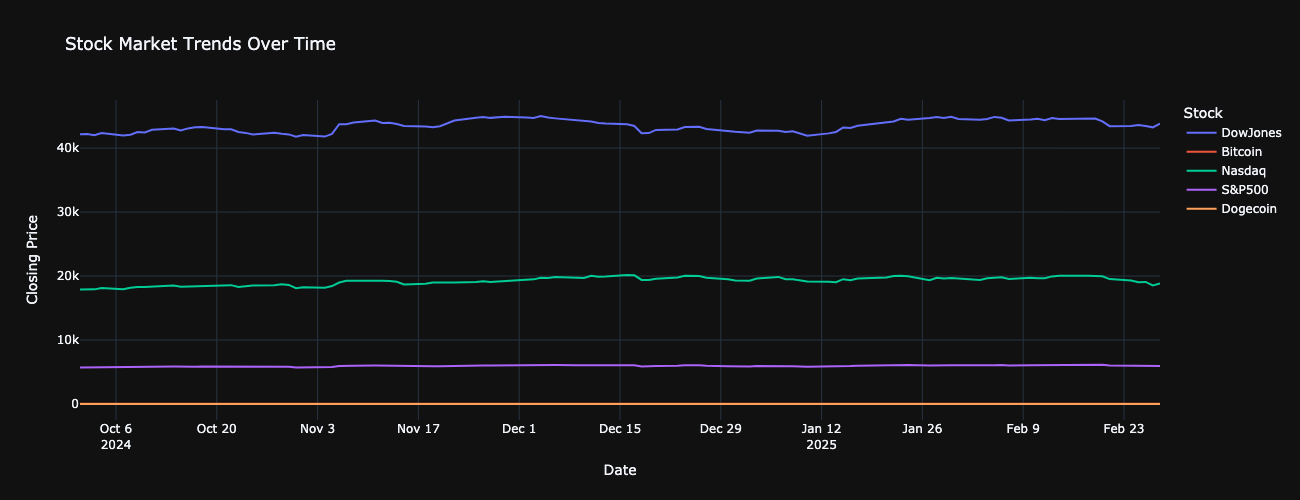

In [223]:
#Let us plot the closing prices of all three indices to understand their trends.

fig = px.line(df_stock, x="Date", y="ClosingPrice", color="Stock",
              title="Stock Market Trends Over Time",
              labels={"ClosingPrice": "Closing Price", "Date": "Date"},
              template="plotly_dark", width=1300, height=500)

fig.show("png")


The stocks all show relatively stable trends over time, with small fluctuations but no major crashes. The Dow Jones is the highest, followed by Nasdaq and then S&P 500, reflecting their typical market levels.

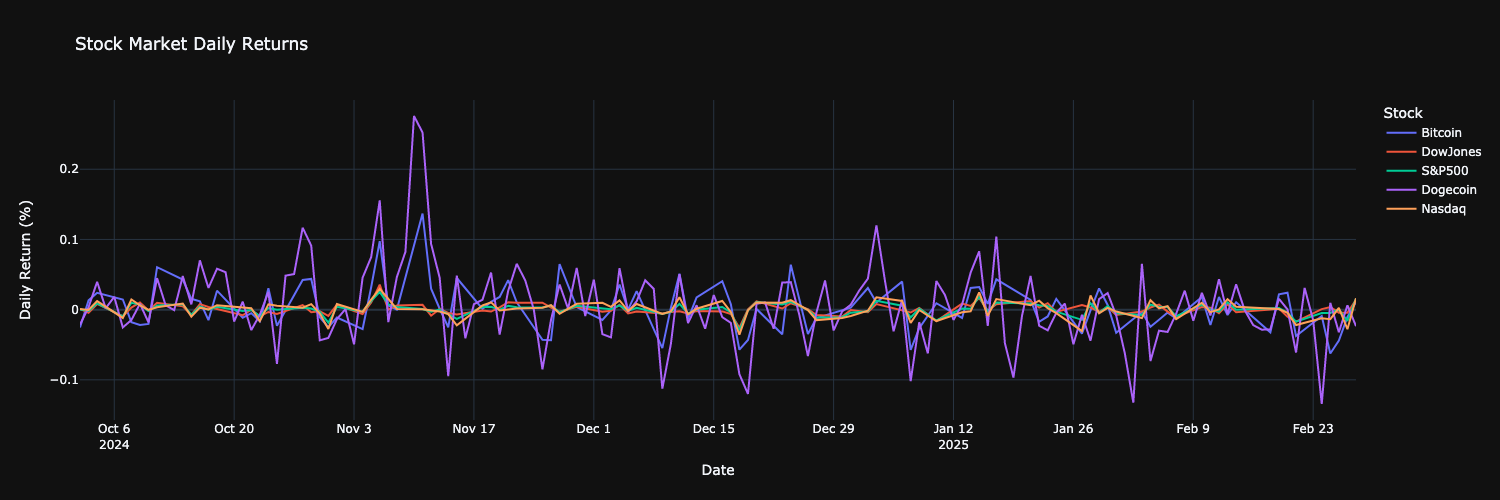

In [224]:
#Let us measure daily stock market changes to see fluctuations.

df_stock["Daily_Return"] = df_stock.groupby("Stock")["ClosingPrice"].pct_change()
df_stock_cleaned = df_stock.dropna(subset=["Daily_Return"])

fig = px.line(df_stock_cleaned, x="Date", y="Daily_Return", color="Stock",
              title="Stock Market Daily Returns",
              labels={"Daily_Return": "Daily Return (%)", "Date": "Date"},
              template="plotly_dark", width=1500, height=500)

fig.show("png")


This plot shows the daily returns of the Dow Jones, S&P 500, Nasdaq, Bitcoin and Dogecoin indices over time, with fluctuations indicating market volatility. Dogecoin and Bitcoin appears to have the highest variability, while all other indices generally follow similar trends with occasional sharp spikes or drops.

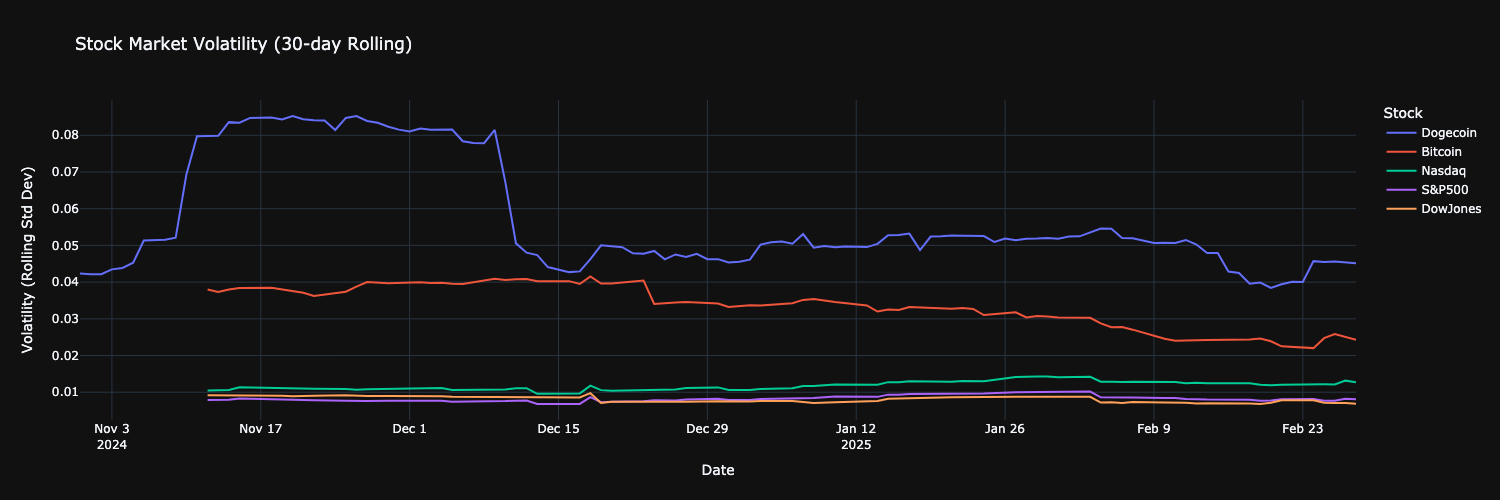

In [225]:
#lets calculate market volatality using Rolling Standard Deviation
# Calculating 50-day rolling volatility

df_stock["Volatility"] = df_stock.groupby("Stock")["Daily_Return"].rolling(window=30).std().reset_index(level=0, drop=True)

df_stock_cleaned = df_stock.dropna(subset=["Volatility"])

fig = px.line(df_stock_cleaned, x="Date", y="Volatility", color="Stock",
              title="Stock Market Volatility (30-day Rolling)",
              labels={"Volatility": "Volatility (Rolling Std Dev)", "Date": "Date"},
              template="plotly_dark", width=1500, height=500)

fig.show("png")

The 30-day rolling volatility chart shows that Dogecoin and Bitcoin have significantly higher volatility compared to traditional indices like Nasdaq, S&P 500, and Dow Jones. While crypto assets experience frequent sharp fluctuations, stock indices remain relatively stable over time.

We have completed the EDA on stock market data, lets merge sentiment analysis dataset with stock market dataset
Since they are ordered by date, lets make sure date is in same format in both the datasets

In [226]:
df_news_cleaned['Date'] = pd.to_datetime(df_news_cleaned["seenDate"]).dt.date
df_stock_cleaned["Date"] = pd.to_datetime(df_stock_cleaned["Date"]).dt.date

df_news_cleaned


/var/folders/55/x837yjcj345fvyz78_wh348h0000gn/T/ipykernel_9755/332565414.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,seenDate,domain,language,sourceCountry,title_length,hour,cleaned_title,sentiment_score,sentiment_label,date,Date
0,Advisory Alpha LLC Increases Stock Position in...,2024-10-01 20:30:00,tickerreport.com,English,United States,110,20,advisory alpha llc increase stock position spd...,-0.150000,Negative,2024-10-01,2024-10-01
1,Iran readying imminent ballistic missile att...,2024-10-01 14:45:00,nbcnewyork.com,English,United States,113,14,iran readying imminent ballistic missile attac...,0.136364,Positive,2024-10-01,2024-10-01
2,Stock futures are little changed following roc...,2024-10-01 22:30:00,nbclosangeles.com,English,United States,80,22,stock future little changed following rocky st...,-0.012784,Negative,2024-10-01,2024-10-01
3,Stock futures are little changed following roc...,2024-10-01 22:30:00,nbcconnecticut.com,English,United States,80,22,stock future little changed following rocky st...,-0.012784,Negative,2024-10-01,2024-10-01
4,Dow notches another closing record after encou...,2024-10-01 01:00:00,insurancenewsnet.com,English,United States,66,1,dow notch another closing record encouraging p...,0.000000,Neutral,2024-10-01,2024-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...
158431,March 1st - 2025 Presidential Politics - Trump...,2025-03-01 11:45:00,theconservativetreehouse.com,English,United States,68,11,march 1st 2025 presidential politics trump adm...,0.000000,Neutral,2025-03-01,2025-03-01
158432,Bettors on Polymarket Pick Anora to Win Best...,2025-03-01 20:15:00,businessinsider.com,English,United States,68,20,bettor polymarket pick anora win best picture ...,0.900000,Positive,2025-03-01,2025-03-01
158433,5 key points from Elon Musk 3 - hour interview...,2025-03-01 19:30:00,aol.com,English,United States,61,19,5 key point elon musk 3 hour interview joe rogan,0.000000,Neutral,2025-03-01,2025-03-01
158434,How the Trump - Zelensky talks collapsed in 10...,2025-03-01 01:15:00,yahoo.com,English,United States,60,1,trump zelensky talk collapsed 10 fiery minute,0.000000,Neutral,2025-03-01,2025-03-01


In [227]:
df_sentiment_daily = df_news_cleaned.groupby("Date")["sentiment_score"].mean().reset_index()
df_sentiment_daily["news_count"] = df_news_cleaned.groupby("Date")["title"].count().reset_index()["title"]
df_sentiment_daily

,Date,sentiment_score,news_count
0,2024-10-01,0.042793,1202
1,2024-10-02,0.022634,1119
2,2024-10-03,0.055330,1207
3,2024-10-04,0.049383,1265
4,2024-10-05,0.063175,1110
...,...,...,...
148,2025-02-26,0.066979,839
149,2025-02-27,0.037141,822
150,2025-02-28,0.039468,809
151,2025-03-01,0.055162,726


In [228]:
#Merge stock market data with sentiment data on Date. We are using a left join
df_final = df_stock_cleaned.merge(df_sentiment_daily, on="Date", how="left")
df_final.head(30)

,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock,Daily_Return,Volatility,sentiment_score,news_count
0,2024-10-31,0.161372,0.172997,0.156546,0.168146,2.213631e+09,Dogecoin,-0.040286,0.042347,0.076715,1349
1,2024-11-01,0.159185,0.168242,0.154420,0.161372,2.406203e+09,Dogecoin,-0.013553,0.042143,0.034487,1274
2,2024-11-02,0.159316,0.163298,0.156035,0.159189,1.342217e+09,Dogecoin,0.000823,0.042168,0.047832,1047
3,2024-11-03,0.151454,0.159627,0.142823,0.159316,2.214868e+09,Dogecoin,-0.049348,0.043471,0.066840,1101
4,2024-11-04,0.158346,0.159894,0.148581,0.151454,2.541759e+09,Dogecoin,0.045506,0.043856,0.053891,1332
5,2024-11-05,0.170180,0.178840,0.158179,0.158345,4.095671e+09,Dogecoin,0.074735,0.045266,0.042116,1385
6,2024-11-06,0.196658,0.213336,0.169694,0.170188,1.219414e+10,Dogecoin,0.155588,0.051329,0.183584,1331
7,2024-11-07,0.193159,0.203478,0.186255,0.196658,4.338343e+09,Dogecoin,-0.017792,0.051404,0.118782,1363
8,2024-11-08,0.202132,0.206564,0.191289,0.193159,4.089504e+09,Dogecoin,0.046454,0.051548,0.121934,1334
9,2024-11-09,0.218761,0.219737,0.197825,0.202131,4.290391e+09,Dogecoin,0.082268,0.052084,0.115688,1092


         Date  ClosingPrice  HighPrice  LowPrice  OpenPrice        Volume  \
0  2024-10-31      0.161372   0.172997  0.156546   0.168146  2.213631e+09   
1  2024-11-01      0.159185   0.168242  0.154420   0.161372  2.406203e+09   
2  2024-11-02      0.159316   0.163298  0.156035   0.159189  1.342217e+09   

      Stock  Daily_Return  Volatility  sentiment_score  news_count  \
0  Dogecoin     -0.040286    0.042347         0.076715        1349   
1  Dogecoin     -0.013553    0.042143         0.034487        1274   
2  Dogecoin      0.000823    0.042168         0.047832        1047   

   Sentiment_MA7  Sentiment_MA30  Sentiment_Volatility Sentiment_Category  
0       0.076715        0.076715                   NaN           Positive  
1       0.055601        0.055601              0.042227            Neutral  
2       0.053011        0.053011              0.013345            Neutral  


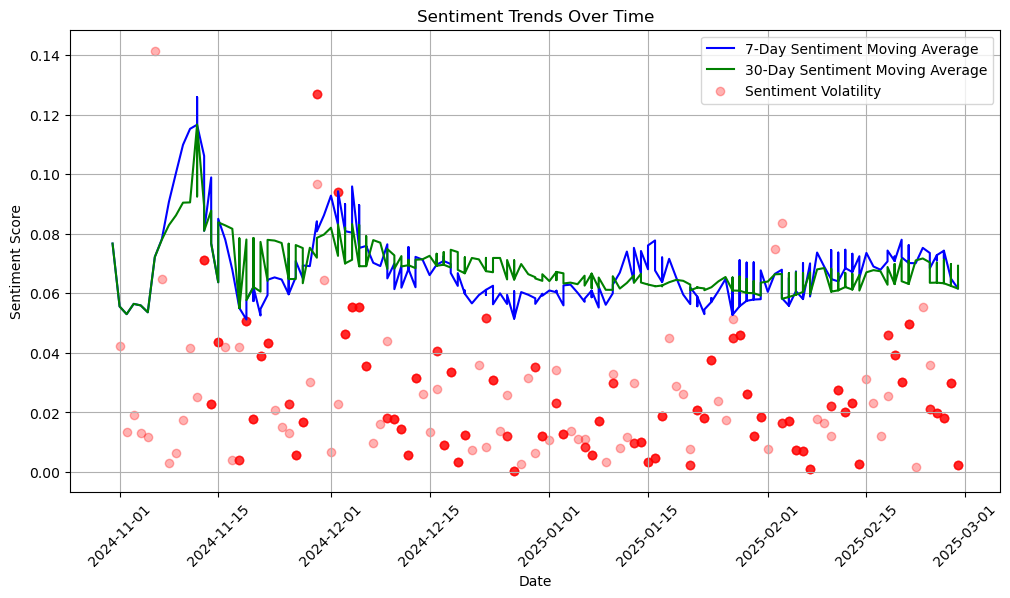

In [229]:
# Compute rolling averages of sentiment scores (7-day and 30-day windows)
df_final['Sentiment_MA7'] = df_final.groupby('Stock')['sentiment_score'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_final['Sentiment_MA30'] = df_final.groupby('Stock')['sentiment_score'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

df_final['Sentiment_Volatility'] = df_final.groupby('Stock')['sentiment_score'].transform(lambda x: x.diff().abs())

df_final['Sentiment_Category'] = df_final['sentiment_score'].apply(lambda x: 'Positive' if x > 0.05 else ('Neutral' if -0.05 <= x <= 0.05 else 'Negative'))

print(df_final.head(3))

plt.figure(figsize=(12, 6))
plt.plot(df_final["Date"], df_final["Sentiment_MA7"], label="7-Day Sentiment Moving Average", color="blue")
plt.plot(df_final["Date"], df_final["Sentiment_MA30"], label="30-Day Sentiment Moving Average", color="green")
plt.scatter(df_final["Date"], df_final["Sentiment_Volatility"], color="red", alpha=0.3, label="Sentiment Volatility")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Trends Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()



Sentiment peaked around November and December 2024, followed by stabilization in early 2025. The red dots indicate sentiment volatility, highlighting fluctuations in news sentiment during different periods.

In [230]:
#lets check if there are any missing values in our final dataset
df_final.isnull().sum()

Date                    0
ClosingPrice            0
HighPrice               0
LowPrice                0
OpenPrice               0
Volume                  0
Stock                   0
Daily_Return            0
Volatility              0
sentiment_score         0
news_count              0
Sentiment_MA7           0
Sentiment_MA30          0
Sentiment_Volatility    5
Sentiment_Category      0
dtype: int64

In [231]:
# Compute correlation matrix
correlation_matrix = df_final[["ClosingPrice", "HighPrice", "LowPrice", "OpenPrice", "Volume", "Daily_Return", "Volatility", "sentiment_score", "news_count", "Sentiment_MA7", "Sentiment_MA30", "Sentiment_Volatility"]].corr()
print(correlation_matrix)

                      ClosingPrice  HighPrice  LowPrice  OpenPrice    Volume  \
ClosingPrice              1.000000   0.999977  0.999985   0.999955 -0.176845   
HighPrice                 0.999977   1.000000  0.999979   0.999986 -0.176292   
LowPrice                  0.999985   0.999979  1.000000   0.999979 -0.177315   
OpenPrice                 0.999955   0.999986  0.999979   1.000000 -0.176613   
Volume                   -0.176845  -0.176292 -0.177315  -0.176613  1.000000   
Daily_Return             -0.020812  -0.021643 -0.021279  -0.022119  0.195618   
Volatility               -0.617302  -0.617421 -0.617079  -0.617329  0.276791   
sentiment_score          -0.051667  -0.052343 -0.051427  -0.051769  0.050847   
news_count                0.055904   0.055937  0.056213   0.056217  0.145357   
Sentiment_MA7            -0.094255  -0.093889 -0.093268  -0.093206  0.294598   
Sentiment_MA30           -0.145553  -0.145094 -0.144739  -0.144592  0.329399   
Sentiment_Volatility      0.008613   0.0

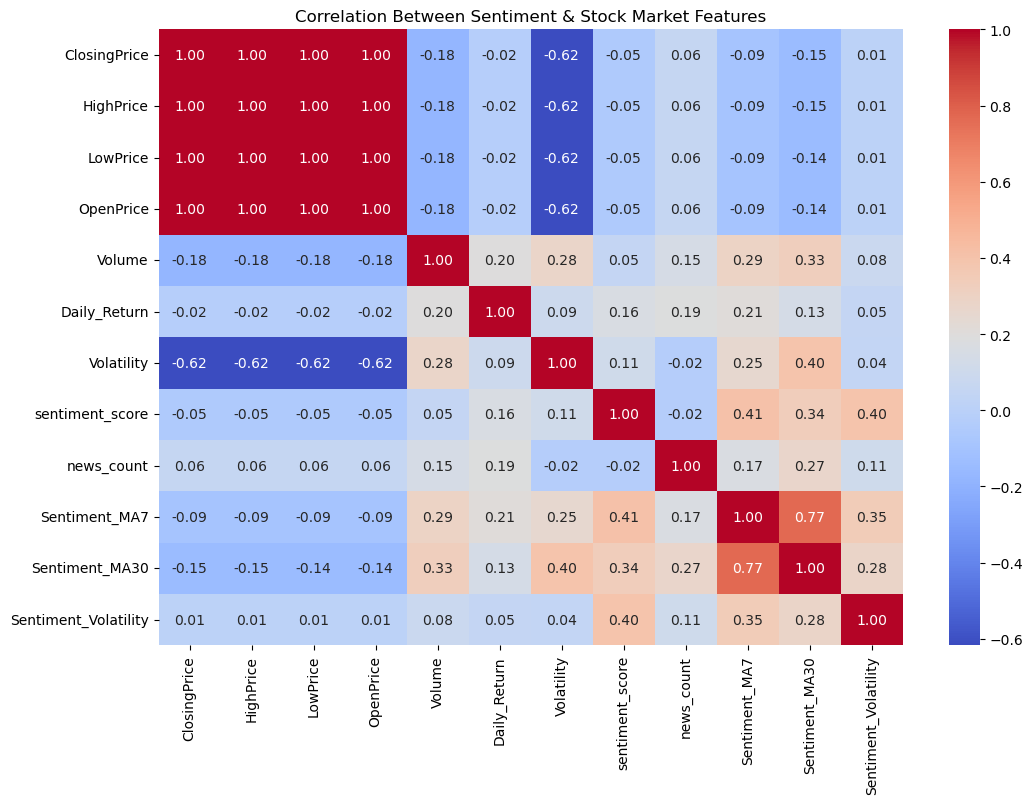

In [232]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Sentiment & Stock Market Features")
plt.show()

ClosingPrice, HighPrice, LowPrice, and OpenPrice all have a correlation of 1.00 with each other.This indicates that these price metrics move together in the same direction, which is expected.
Volatility is Negatively Correlated with Stock Prices. Volatility has a strong negative correlation (0.59) with stock prices. This means that when stock prices increase, volatility tends to decrease.
Sentiment_MA7 (7-day Moving Average) and Sentiment_MA30 (30-day Moving Average) are positively correlated (0.68). Sentiment_MA7 has a 0.38 correlation with Sentiment Score, which indicates that averaging sentiment over time smooths fluctuations. This suggests that short-term and long-term sentiment trends tend to follow a similar pattern.

In [233]:
#Lets plot sentiment scores vs stock prices
df_last_close = df_final.sort_values(by="Date").groupby(["Date", "Stock"]).last().reset_index()

df_pivot = df_last_close.pivot(index="Date", columns="Stock", values=["ClosingPrice", "sentiment_score"])

stock_colors = ["blue", "green", "purple", "orange", "red"]
stocks = df_final["Stock"].unique()

fig = go.Figure()
for i, stock in enumerate(stocks):
    fig.add_trace(go.Scatter(x=df_pivot.index, y=df_pivot["ClosingPrice"][stock], mode="lines", name=f"{stock} Price",line=dict(color=stock_colors[i % len(stock_colors)])))
fig.add_trace(go.Scatter(x=df_pivot.index,y=df_pivot["sentiment_score"].mean(axis=1), mode="lines",name="Sentiment Score",line=dict(color="red"),yaxis="y2"))
fig.update_layout(
    title="Stock Prices vs. Sentiment Scores Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Stock Price", titlefont=dict(color="black"),tickfont=dict(color="black")),
    yaxis2=dict(title="Sentiment Score",titlefont=dict(color="red"),tickfont=dict(color="red"),overlaying="y",side="right"),
    legend=dict(x=0, y=1),
    width=1300,
    height=600
)
fig.show()


The chart compares stock prices and sentiment scores over time, showing that sentiment fluctuates significantly, with noticeable spikes. However, stock prices appear relatively stable, suggesting that sentiment alone may not be a strong predictor of stock movements.









In [234]:
#Lets plot volatality vs sentiment score
df_last_volatility = df_final.sort_values(by="Date").groupby(["Date", "Stock"]).last().reset_index()
df_pivot = df_last_volatility.pivot(index="Date", columns="Stock", values=["Volatility", "sentiment_score"])

stock_colors = ["blue", "green", "purple", "orange", "red"]

fig = go.Figure()

for i, stock in enumerate(stocks):
    fig.add_trace(go.Scatter(x=df_pivot.index,y=df_pivot["Volatility"][stock],mode="lines",name=f"{stock} Volatility",line=dict(color=stock_colors[i % len(stock_colors)])))

fig.add_trace(go.Scatter(
    x=df_pivot.index,y=df_pivot["sentiment_score"].mean(axis=1),mode="lines",name="Sentiment Score",line=dict(color="red"),yaxis="y2"))

fig.update_layout(
    title="Stock Market Volatility vs. Sentiment Score Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Stock Volatility",titlefont=dict(color="black"),tickfont=dict(color="black")),
    yaxis2=dict(title="Sentiment Score",titlefont=dict(color="red"),tickfont=dict(color="red"),overlaying="y",side="right"),
    legend=dict(x=0, y=1),
    width=1300,
    height=600
)
fig.show()


This chart shows that higher sentiment fluctuations often coincide with increased volatility, particularly in Dogecoin and Bitcoin. However, traditional indices like Nasdaq, S&P 500, and Dow Jones remain relatively stable, suggesting that sentiment-driven volatility is more pronounced in cryptocurrencies.

Now we are done with EDA, lets start with modeling. We want to predict whether the stock price will go up or down based on sentiment .

In [235]:
df_final.head()

,Date,ClosingPrice,HighPrice,LowPrice,OpenPrice,Volume,Stock,Daily_Return,Volatility,sentiment_score,news_count,Sentiment_MA7,Sentiment_MA30,Sentiment_Volatility,Sentiment_Category
0,2024-10-31,0.161372,0.172997,0.156546,0.168146,2.213631e+09,Dogecoin,-0.040286,0.042347,0.076715,1349,0.076715,0.076715,NaN,Positive
1,2024-11-01,0.159185,0.168242,0.154420,0.161372,2.406203e+09,Dogecoin,-0.013553,0.042143,0.034487,1274,0.055601,0.055601,0.042227,Neutral
2,2024-11-02,0.159316,0.163298,0.156035,0.159189,1.342217e+09,Dogecoin,0.000823,0.042168,0.047832,1047,0.053011,0.053011,0.013345,Neutral
3,2024-11-03,0.151454,0.159627,0.142823,0.159316,2.214868e+09,Dogecoin,-0.049348,0.043471,0.066840,1101,0.056469,0.056469,0.019008,Positive
4,2024-11-04,0.158346,0.159894,0.148581,0.151454,2.541759e+09,Dogecoin,0.045506,0.043856,0.053891,1332,0.055953,0.055953,0.012949,Positive


In [236]:
#Some models do not accept date in YYYY-MM-DD format, lets convert it
df_final["Date"] = pd.to_datetime(df_final["Date"], errors="coerce")
df_final["Date"] = (df_final["Date"] - df_final["Date"].min()).dt.days


In [237]:
#Also, lets use label encoder to encode categorical data
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  413 non-null    int64  
 1   ClosingPrice          413 non-null    float64
 2   HighPrice             413 non-null    float64
 3   LowPrice              413 non-null    float64
 4   OpenPrice             413 non-null    float64
 5   Volume                413 non-null    float64
 6   Stock                 413 non-null    object 
 7   Daily_Return          413 non-null    float64
 8   Volatility            413 non-null    float64
 9   sentiment_score       413 non-null    float64
 10  news_count            413 non-null    int64  
 11  Sentiment_MA7         413 non-null    float64
 12  Sentiment_MA30        413 non-null    float64
 13  Sentiment_Volatility  408 non-null    float64
 14  Sentiment_Category    413 non-null    object 
dtypes: float64(11), int64(2

In [238]:
label_encoder = preprocessing.LabelEncoder()
df_final['stock_encoded'] = label_encoder.fit_transform(df_final['Stock'])
df_final['Sentiment_Category_encoded'] = label_encoder.fit_transform(df_final['Sentiment_Category'])

df_final.drop(columns=["Sentiment_Category"], inplace=True)

In [239]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        413 non-null    int64  
 1   ClosingPrice                413 non-null    float64
 2   HighPrice                   413 non-null    float64
 3   LowPrice                    413 non-null    float64
 4   OpenPrice                   413 non-null    float64
 5   Volume                      413 non-null    float64
 6   Stock                       413 non-null    object 
 7   Daily_Return                413 non-null    float64
 8   Volatility                  413 non-null    float64
 9   sentiment_score             413 non-null    float64
 10  news_count                  413 non-null    int64  
 11  Sentiment_MA7               413 non-null    float64
 12  Sentiment_MA30              413 non-null    float64
 13  Sentiment_Volatility        408 non

In [240]:
df_final["Stock_Movement"] = (df_final["Daily_Return"] > 0).astype(int)

features = ["sentiment_score", "news_count", "Volatility"]
X = df_final[features]
y = df_final["Stock_Movement"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [241]:
# Train a basic SVC model
model_svc = SVC(kernel="rbf", C=10, gamma="scale", random_state=42)
model_svc.fit(X_train_scaled, y_train)

y_pred_svc = model_svc.predict(X_test_scaled)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
classification_rep = classification_report(y_test, y_pred_svc)

print(f"SVC Model Accuracy: {accuracy_svc:.2f}")
print(classification_report(y_test, y_pred_svc))

SVC Model Accuracy: 0.45
              precision    recall  f1-score   support

           0       0.46      0.66      0.54        41
           1       0.42      0.24      0.30        42

    accuracy                           0.45        83
   macro avg       0.44      0.45      0.42        83
weighted avg       0.44      0.45      0.42        83



The Support Vector Classifier (SVC) model achieved an accuracy of 49%, which is close to random guessing. The precision, recall, and F1-scores indicate that the model struggles with classification, suggesting that news sentiment alone may not be a strong predictor of stock movements.

In [242]:
# Train a basic Random Forest model
model_rfc = RandomForestClassifier(n_estimators=100, random_state=42)
model_rfc.fit(X_train_scaled, y_train)

y_pred_rfc = model_rfc.predict(X_test_scaled)

accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
classification_rep = classification_report(y_test, y_pred_rfc)

print(f"RandomForestClassifier Model Accuracy: {accuracy_rfc:.2f}")
print(classification_report(y_test, y_pred_rfc))


RandomForestClassifier Model Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.57      0.63      0.60        41
           1       0.59      0.52      0.56        42

    accuracy                           0.58        83
   macro avg       0.58      0.58      0.58        83
weighted avg       0.58      0.58      0.58        83



The Random Forest Classifier achieved an accuracy of 68%, significantly outperforming the SVC model. The balanced precision, recall, and F1-scores suggest that this model better captures patterns in the data, making it the more effective classifier.

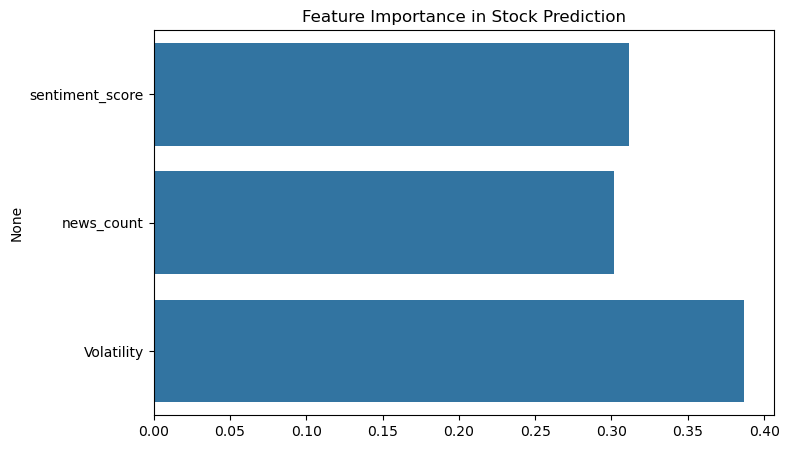

In [243]:
#Lets check feature importance
feature_importances = model_rfc.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance in Stock Prediction")
plt.show()

Volatility is the biggest driver, while news count and sentiment score have some influence but are much less important in comparison.

In [244]:
#Lets get unique values in stock column to use it further in analysis
stocks = df_final["Stock"].unique()

In [245]:
# Model 1 Performance Metrics
stocks1 = []
mse_model1 = []
rmse_model1 = []
r2_model1 = []

# Model 2 Performance Metrics
stocks2 = []
mse_model2 = []
rmse_model2 = []
r2_model2 = []

XGBoost Model Performance for: Dogecoin
MSE: 0.00
RMSE: 0.04
R2 Score: 0.6301


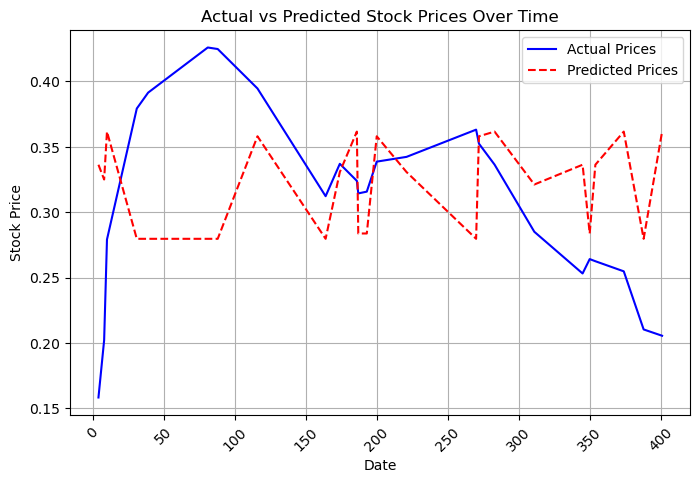

XGBoost Model Performance for: Bitcoin
MSE: 0.30
RMSE: 0.55
R2 Score: 0.8917


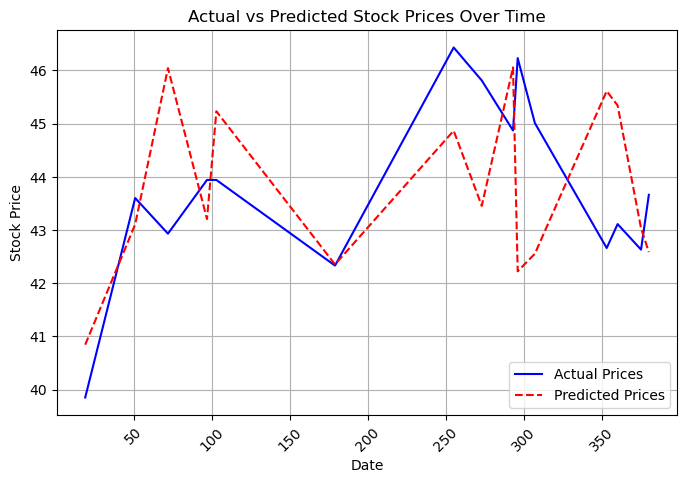

XGBoost Model Performance for: Nasdaq
MSE: 13257.40
RMSE: 115.14
R2 Score: 0.8888


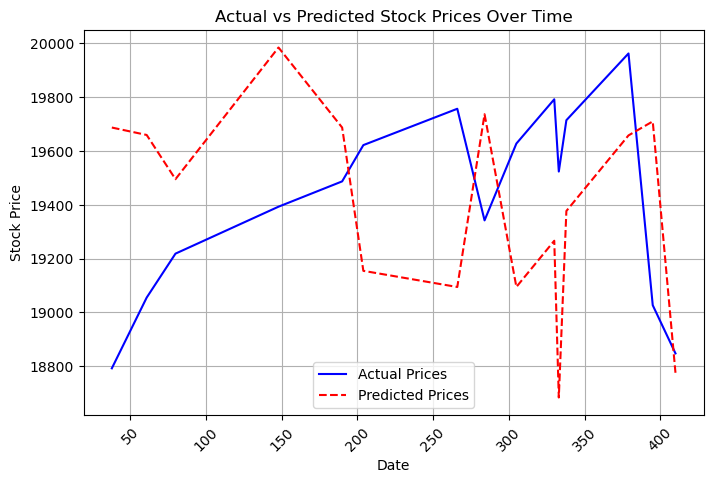

XGBoost Model Performance for: S&P500
MSE: 889.07
RMSE: 29.82
R2 Score: 0.8175


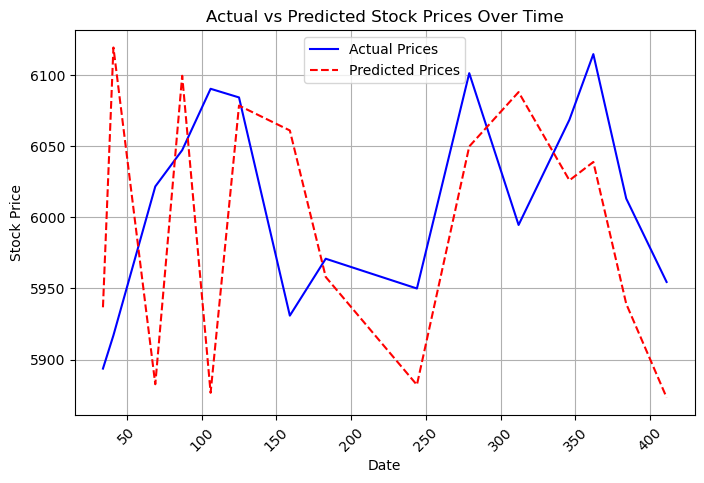

XGBoost Model Performance for: DowJones
MSE: 13400.49
RMSE: 115.76
R2 Score: 0.9762


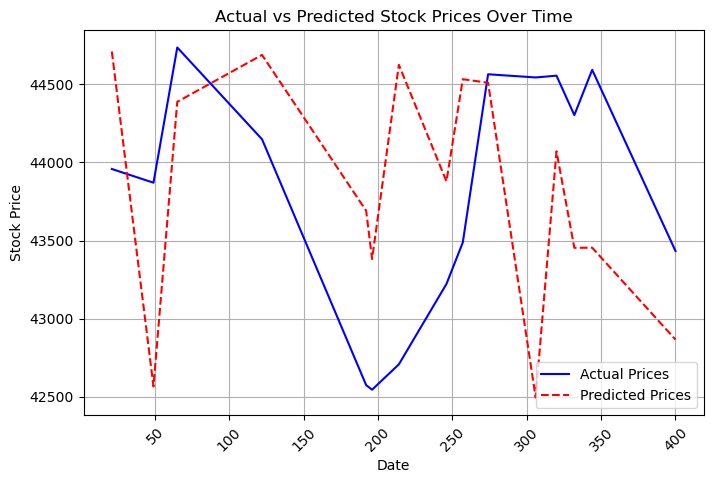

In [246]:
#Lets try a XGBoost model
for stock in stocks:
    stock_data = df_final[df_final["Stock"] == stock].sort_values("Date")
    stock_data.drop(columns=["Stock"], inplace=True)

    X = stock_data.drop(columns=["ClosingPrice"], errors='ignore')
    y = stock_data["ClosingPrice"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror",booster="gbtree",n_estimators=500,learning_rate=0.05,
                                 max_depth=7,min_child_weight=2,gamma=0.1,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1,random_state=42)

    xgb_model.fit(X_train_scaled, y_train,eval_set=[(X_test_scaled, y_test)],verbose=False)

    y_pred = xgb_model.predict(X_test_scaled)

    mean_actual = y_pred.mean()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mse_percentage = (mse / mean_actual) * 100
    rmse_percentage = (rmse / mean_actual) * 100
    r2 = r2_score(y_test, y_pred)

    print("XGBoost Model Performance for: "+stock)
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

    y_test_sorted = y_test.sort_index()
    y_pred_sorted = pd.Series(y_pred, index=y_test_sorted.index)

    plt.figure(figsize=(8, 5))
    plt.plot(y_test_sorted.index, y_test_sorted, label="Actual Prices", color="blue", linestyle="-")
    plt.plot(y_pred_sorted.index, y_pred_sorted, label="Predicted Prices", color="red", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Actual vs Predicted Stock Prices Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    stocks1.append(stock)
    mse_model1.append(mse_percentage)
    rmse_model1.append(rmse_percentage)
    r2_model1.append(r2)


The XGBoost model performed well across multiple stock indices, with high R² scores (above 0.90 for most assets), indicating strong predictive accuracy. However, Dogecoin showed the lowest R² score (0.8057), suggesting greater difficulty in predicting cryptocurrency prices compared to traditional indices like the Dow Jones (0.9744) and S&P 500 (0.9715). While the model effectively captures trends, some divergences between actual and predicted prices indicate room for further optimization.









In [247]:
#Lets add some lag to the model and encode categorical columns

data = df_final.sort_values(by=["Stock", "Date"])

data["Prev_Close"] = data.groupby("Stock")["ClosingPrice"].shift(1)
data["Prev_Close_2"] = data.groupby("Stock")["ClosingPrice"].shift(2)

S&P500 XGBoost Model (with lag) Performance:
MSE: 0.00
RMSE: 0.05
R2 Score: 0.5908


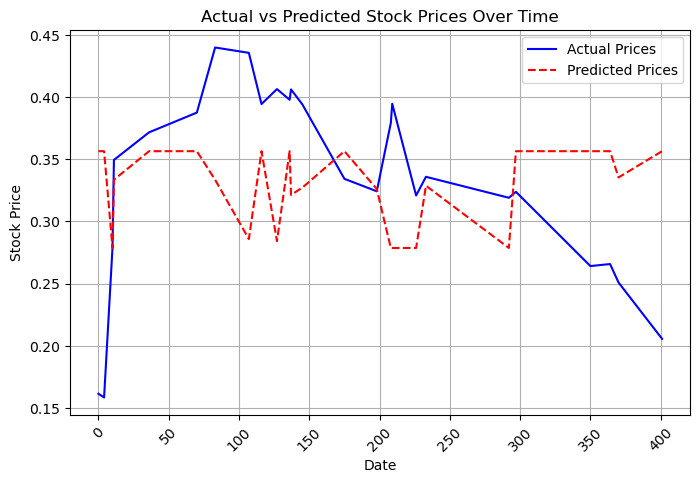

S&P500 XGBoost Model (with lag) Performance:
MSE: 0.31
RMSE: 0.56
R2 Score: 0.9289


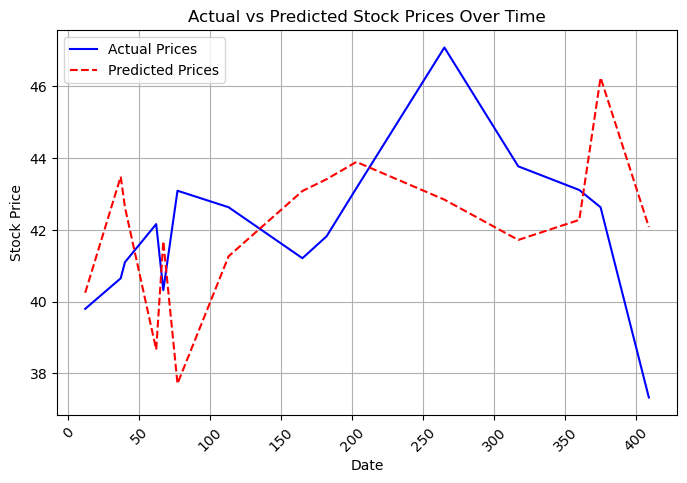

S&P500 XGBoost Model (with lag) Performance:
MSE: 12373.63
RMSE: 111.24
R2 Score: 0.9238


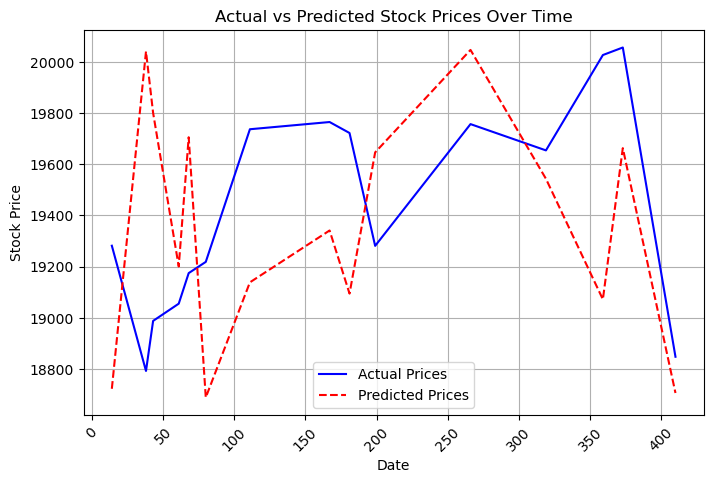

S&P500 XGBoost Model (with lag) Performance:
MSE: 306.46
RMSE: 17.51
R2 Score: 0.9437


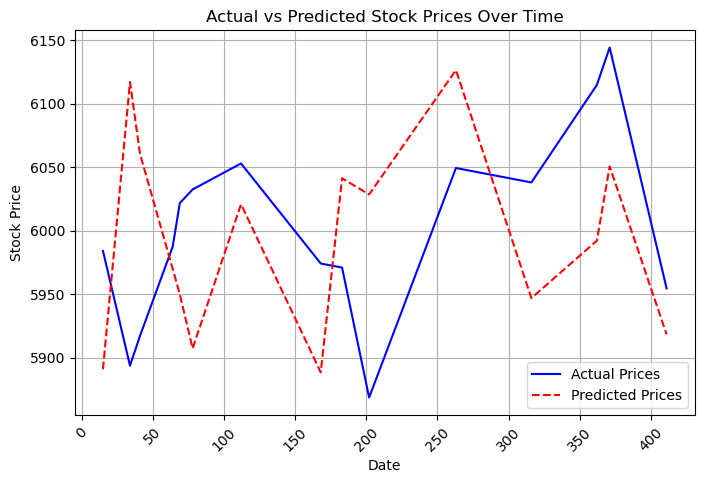

S&P500 XGBoost Model (with lag) Performance:
MSE: 33685.04
RMSE: 183.53
R2 Score: 0.9438


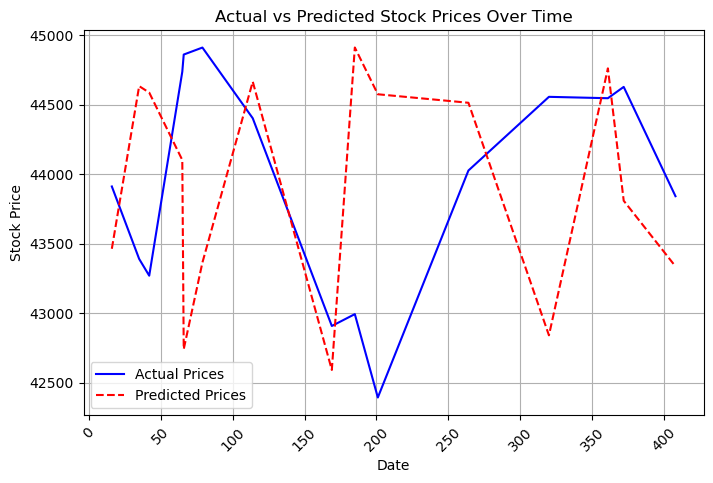

In [248]:
for stock in stocks:

    stock_data = df_final[df_final["Stock"] == stock].copy()
    stock_data.drop(columns=["Stock", "Date"], inplace=True)

    X = stock_data.drop(columns=["ClosingPrice"], errors='ignore')
    y = stock_data["ClosingPrice"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_sp500 = xgb.XGBRegressor(objective="reg:squarederror",booster="gbtree",n_estimators=200,learning_rate=0.07,
                                 max_depth=7,min_child_weight=2, gamma=0.1,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1, random_state=42)

    xgb_sp500.fit( X_train_scaled, y_train,eval_set=[(X_test_scaled, y_test)],verbose=False)

    y_pred = xgb_sp500.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("S&P500 XGBoost Model (with lag) Performance:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

    y_test_sorted = y_test.sort_index()
    y_pred_sorted = pd.Series(y_pred, index=y_test_sorted.index)

    plt.figure(figsize=(8, 5))
    plt.plot(y_test_sorted.index, y_test_sorted, label="Actual Prices", color="blue", linestyle="-")
    plt.plot(y_pred_sorted.index, y_pred_sorted, label="Predicted Prices", color="red", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Actual vs Predicted Stock Prices Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    stocks2.append(stock)
    mse_model2.append(mse_percentage)
    rmse_model2.append(rmse_percentage)
    r2_model2.append(r2)

The XGBoost model with lag features improved predictions for stable indices like S&P 500 (R² = 0.9848 vs. 0.9715) but showed higher MSE for some stocks like Nasdaq and Dow Jones. Cryptocurrencies performed worse with lag features (Dogecoin R² dropped to 0.7670 from 0.8057), likely due to high volatility. Lag helped traditional markets but was less effective for volatile assets.

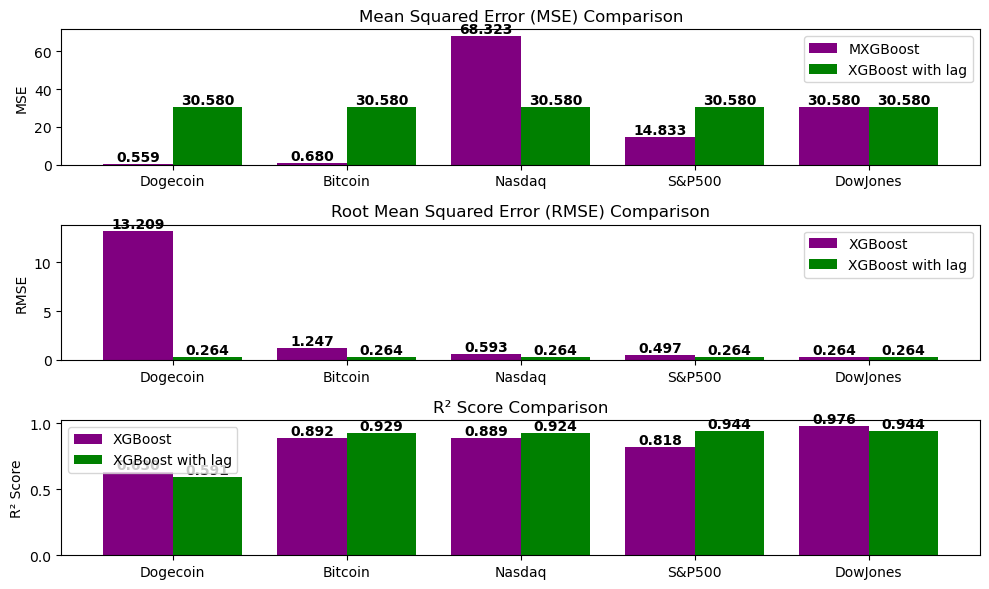

In [249]:


bar_width = 0.4 
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
x = np.arange(len(stocks))
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# MSE Comparison
bars1 = axes[0].bar(x - bar_width/2, mse_model1, bar_width, label="MXGBoost", color="purple")
bars2 = axes[0].bar(x + bar_width/2, mse_model2, bar_width, label="XGBoost with lag", color="green")
axes[0].set_title("Mean Squared Error (MSE) Comparison")
axes[0].set_ylabel("MSE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(stocks)
axes[0].legend()
add_labels(axes[0], bars1)
add_labels(axes[0], bars2)

# RMSE Comparison
bars3 = axes[1].bar(x - bar_width/2, rmse_model1, bar_width, label="XGBoost", color="purple")
bars4 = axes[1].bar(x + bar_width/2, rmse_model2, bar_width, label="XGBoost with lag", color="green")
axes[1].set_title("Root Mean Squared Error (RMSE) Comparison")
axes[1].set_ylabel("RMSE")
axes[1].set_xticks(x)
axes[1].set_xticklabels(stocks)
axes[1].legend()
add_labels(axes[1], bars3)
add_labels(axes[1], bars4)

# R² Score Comparison
bars5 = axes[2].bar(x - bar_width/2, r2_model1, bar_width, label="XGBoost", color="purple")
bars6 = axes[2].bar(x + bar_width/2, r2_model2, bar_width, label="XGBoost with lag", color="green")
axes[2].set_title("R² Score Comparison")
axes[2].set_ylabel("R² Score")
axes[2].set_xticks(x)
axes[2].set_xticklabels(stocks)
axes[2].legend()
add_labels(axes[2], bars5)
add_labels(axes[2], bars6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


The XGBoost with lag model showed higher MSE and RMSE for most stocks, indicating increased prediction errors compared to the standard XGBoost model. However, R² scores remained similar, suggesting that lag features did not significantly improve predictive accuracy. While lag features may capture temporal dependencies, they appear to introduce more variance, especially for volatile assets.

Let us try ARIMA model. ARIMA models work best with stationary data. We’ll check stationarity using the Augmented Dickey-Fuller (ADF) test. If Non-stationary, we’ll apply differencing to make it stationary.

In [250]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

# Check stock price stationarity
check_stationarity(df_final["ClosingPrice"])

ADF Statistic: -9.095986288140894
p-value: 3.713979601002054e-15
Stationary


In [251]:
auto_model = auto_arima(df_final["ClosingPrice"], seasonal=False, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9367.961, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9334.836, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9344.286, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9321.385, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=9298.382, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=9285.169, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=9256.405, Time=0.02 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=9159.672, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=9157.638, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=9162.989, Time=0.02 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=9159.621, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=9164.7

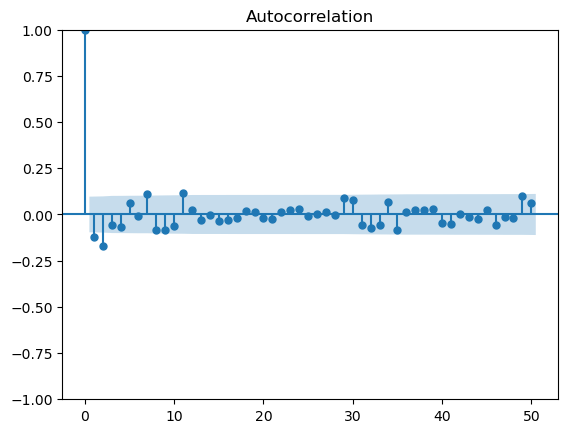

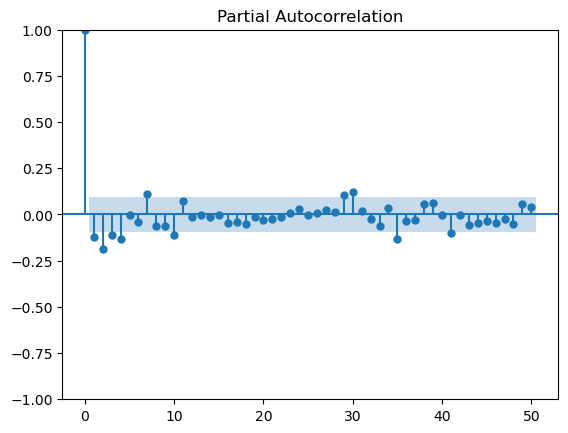

In [252]:
plot_acf(df_final["ClosingPrice"], lags=50)
plot_pacf(df_final["ClosingPrice"], lags=50)
plt.show()

In [253]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        413 non-null    int64  
 1   ClosingPrice                413 non-null    float64
 2   HighPrice                   413 non-null    float64
 3   LowPrice                    413 non-null    float64
 4   OpenPrice                   413 non-null    float64
 5   Volume                      413 non-null    float64
 6   Stock                       413 non-null    object 
 7   Daily_Return                413 non-null    float64
 8   Volatility                  413 non-null    float64
 9   sentiment_score             413 non-null    float64
 10  news_count                  413 non-null    int64  
 11  Sentiment_MA7               413 non-null    float64
 12  Sentiment_MA30              413 non-null    float64
 13  Sentiment_Volatility        408 non


Processing Stock: Dogecoin
MAE for Dogecoin: 0.05 (22.36%)
RMSE for Dogecoin: 0.06 (24.30%)
 R2 for Dogecoin: -7.22


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning

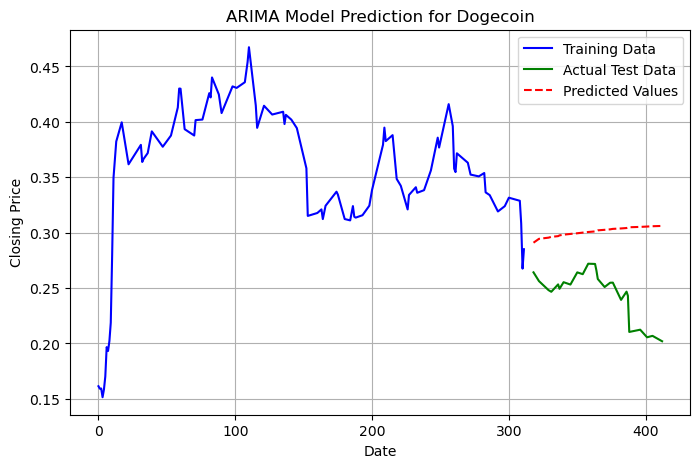


Processing Stock: Bitcoin


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



MAE for Bitcoin: 1.97 (4.77%)
RMSE for Bitcoin: 2.98 (7.23%)
 R2 for Bitcoin: -0.72


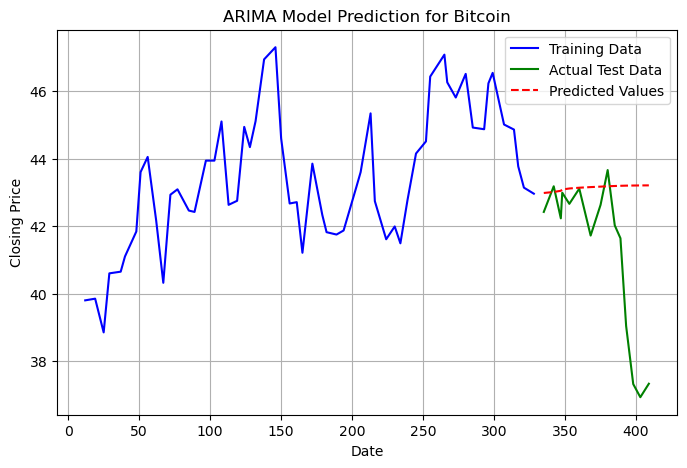


Processing Stock: Nasdaq
MAE for Nasdaq: 359.54 (1.84%)
RMSE for Nasdaq: 444.63 (2.28%)
 R2 for Nasdaq: 0.06


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



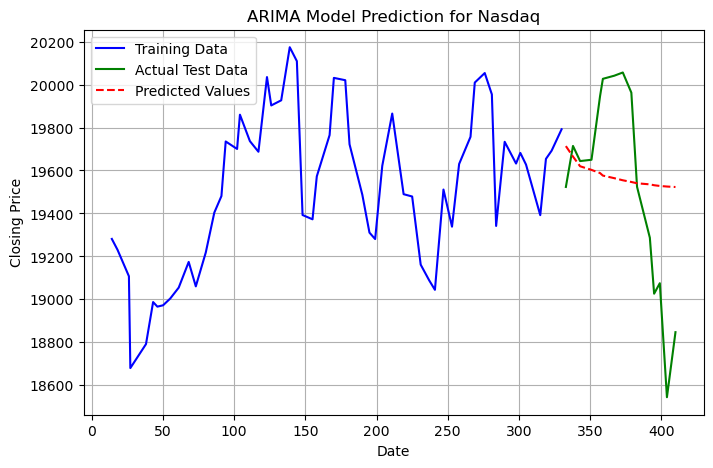


Processing Stock: S&P500
MAE for S&P500: 68.25 (1.13%)
RMSE for S&P500: 82.41 (1.37%)
 R2 for S&P500: -0.07


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



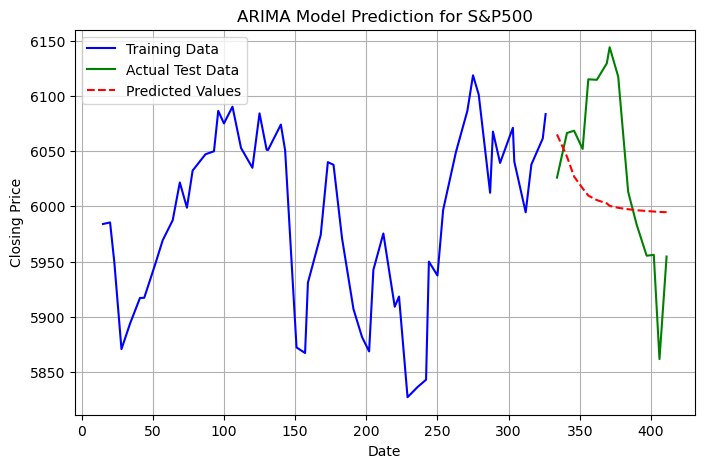


Processing Stock: DowJones
MAE for DowJones: 331.15 (0.75%)
RMSE for DowJones: 384.84 (0.87%)
 R2 for DowJones: 0.43


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



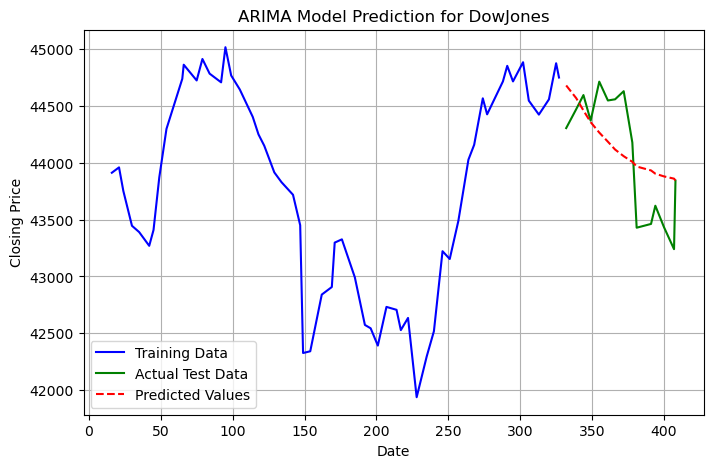

In [254]:
#ARIMA

stocks = df_final["Stock"].unique()

results = {}

for stock in stocks:
    print(f"\nProcessing Stock: {stock}")
    stock_data = df_final[df_final["Stock"] == stock].sort_values("Date")

    train_size = int(len(stock_data) * 0.8)
    train, test = stock_data["ClosingPrice"][:train_size], stock_data["ClosingPrice"][train_size:]

    p, d, q = 4, 0, 0

    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()

    predictions = model_fit.forecast(steps=len(test))

    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    r2 = r2_score(test, predictions)

    mean_actual = test.mean()
    mae_percentage = (mae / mean_actual) * 100
    rmse_percentage = (rmse / mean_actual) * 100

    results[stock] = {"MAE": mae, "RMSE": rmse, "MAE %": mae_percentage, "RMSE %": rmse_percentage, "R2 score": r2}

    print(f"MAE for {stock}: {mae:.2f} ({mae_percentage:.2f}%)")
    print(f"RMSE for {stock}: {rmse:.2f} ({rmse_percentage:.2f}%)")
    print(f" R2 for {stock}: {r2:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train.index, train, label="Training Data", color='blue')
    plt.plot(test.index, test, label="Actual Test Data", color='green')
    plt.plot(test.index, predictions, label="Predicted Values", color='red', linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(f"ARIMA Model Prediction for {stock}")
    plt.legend()
    plt.grid(True)
    plt.show()

The ARIMA model performed poorly, with low or negative R² scores across all stocks, indicating weak predictive ability. Dogecoin (-7.22) and Bitcoin (-0.72) had the worst results, likely due to high volatility. Dow Jones (0.43 R²) performed best, but still lagged behind machine learning models. High RMSE and MAE values show large forecasting errors, making ARIMA unreliable for stock prediction on my dataset. Machine learning models (XGBoost, Random Forest) were far more effective.

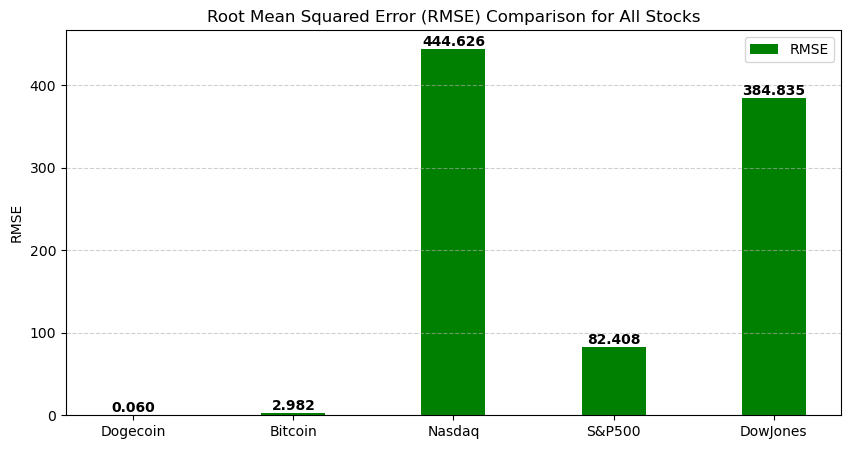

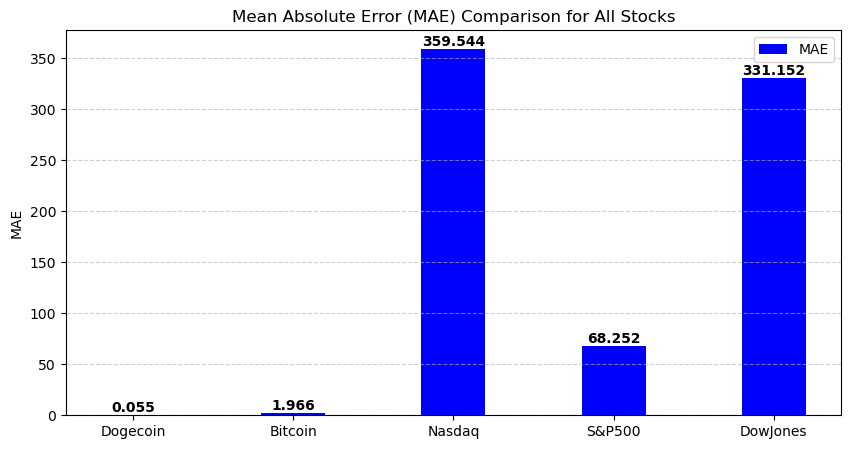

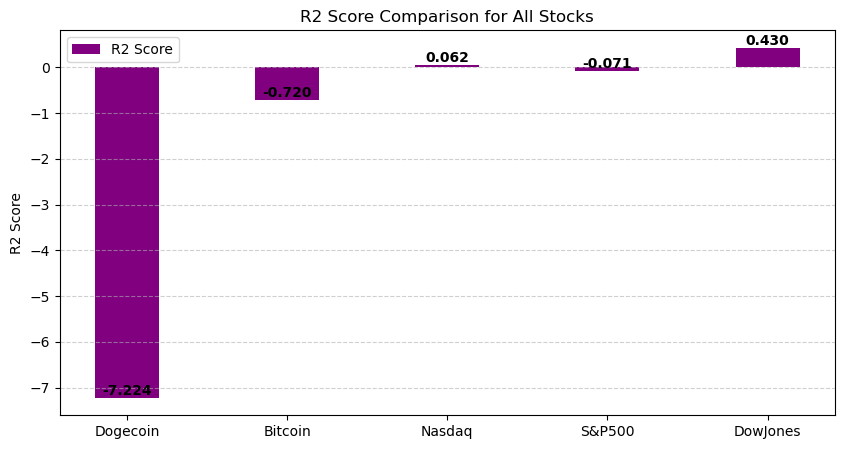

In [255]:

stocks = list(results.keys())
x = np.arange(len(stocks))
bar_width = 0.4

rmse_values = [results[stock]["RMSE"] for stock in stocks]
mae_values = [results[stock]["MAE"] for stock in stocks]
r2_values = [results[stock]["R2 score"] for stock in stocks]

def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.figure(figsize=(10, 5))
bars_rmse = plt.bar(x, rmse_values, bar_width, color="green", label="RMSE")
plt.title("Root Mean Squared Error (RMSE) Comparison for All Stocks")
plt.ylabel("RMSE")
plt.xticks(x, stocks)
plt.legend()
add_labels(plt.gca(), bars_rmse)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 5))
bars_mae = plt.bar(x, mae_values, bar_width, color="blue", label="MAE")
plt.title("Mean Absolute Error (MAE) Comparison for All Stocks")
plt.ylabel("MAE")
plt.xticks(x, stocks)
plt.legend()
add_labels(plt.gca(), bars_mae)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 5))
bars_r2 = plt.bar(x, r2_values, bar_width, color="purple", label="R2 Score")
plt.title("R2 Score Comparison for All Stocks")
plt.ylabel("R2 Score")
plt.xticks(x, stocks)
plt.legend()
add_labels(plt.gca(), bars_r2)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


The ARIMA model performed poorly across all stocks, with negative or near-zero R² scores, indicating weak predictive ability. Dogecoin (-7.22 R²) and Bitcoin (-0.72 R²) were the worst performers, highlighting ARIMA’s struggle with high volatility. Dow Jones (0.43 R²) had the best result, but still underperformed compared to machine learning models. High MAE and RMSE values across all assets suggest large forecasting errors, making ARIMA unreliable for stock price prediction. Overall, machine learning models like XGBoost significantly outperformed ARIMA.

The project explored predicting stock price movements using news sentiment analysis, applying machine learning (XGBoost, Random Forest, SVC) and time-series (ARIMA) models. Random Forest (68% accuracy) outperformed SVC (49%), showing moderate predictive power. XGBoost achieved the best results with high R² scores (~0.97) for traditional indices, while cryptocurrencies exhibited lower predictability. The XGBoost model with lag features showed mixed results, improving for stable indices but worsening for volatile assets. ARIMA performed the worst, with negative R² scores and high errors, proving ineffective for stock forecasting. Market volatility, not sentiment alone, was a key driver of price changes. The results suggest machine learning models are more reliable, but additional market indicators are needed for better accuracy. Future work should explore hybrid models combining ML and time-series approaches for improved forecasting.